### Visualize results from anova, include significance

In [48]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def read_good_units(args):
    args.trial_interval = get_trial_interval(args.trial_event)
    output_dir = io_utils.get_anova_output_dir(args)
    good_res = []
    for feat in FEATURES:
        res = pd.read_pickle(os.path.join(output_dir, f"{feat}_.pickle"))
        # TODO: remove when fixed in run_anova
        shuffle_stats = pd.read_pickle(os.path.join(output_dir, f"{feat}_shuffle_stats.pickle"))
        res = pd.merge(res, shuffle_stats, on="PseudoUnitID")
        good_res.append(res[res.combined_fracvar > res["95th"]])
    good_res = pd.concat(good_res)
    unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))
    # print(unit_pos.columns)
    good_res = pd.merge(good_res, unit_pos[["PseudoUnitID", "drive", "structure_level2"]])
    return good_res

### Visualize a few for response/choice interaction

In [32]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
# args.conditions = ["FeatPreferred"]
args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
# args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}



In [33]:
good_int_res = read_good_units(args)

In [40]:
good_int_res.PseudoUnitID.nunique()

455

### Plots

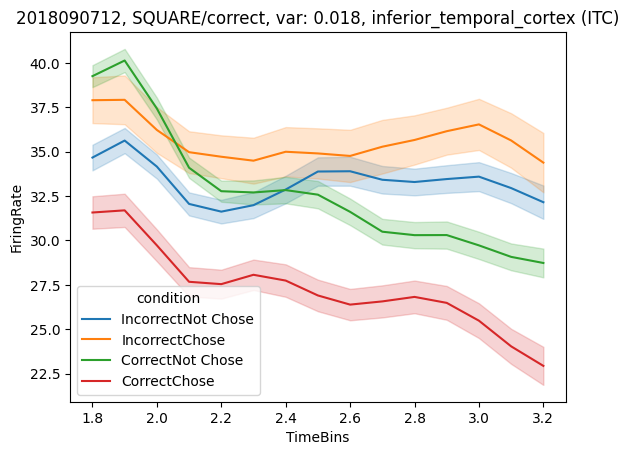

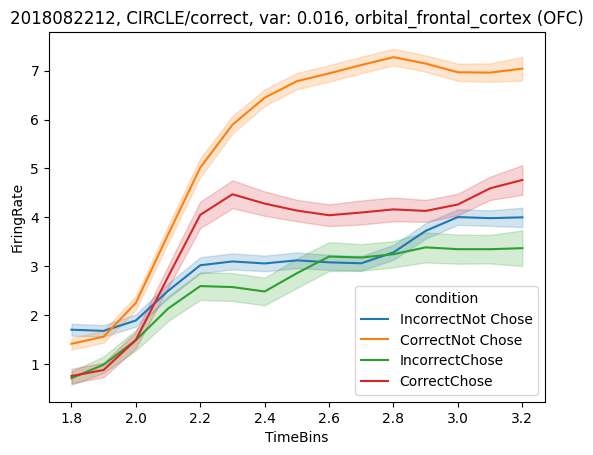

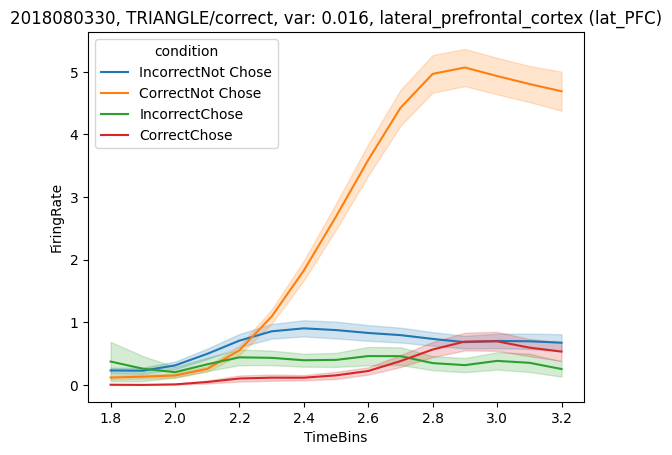

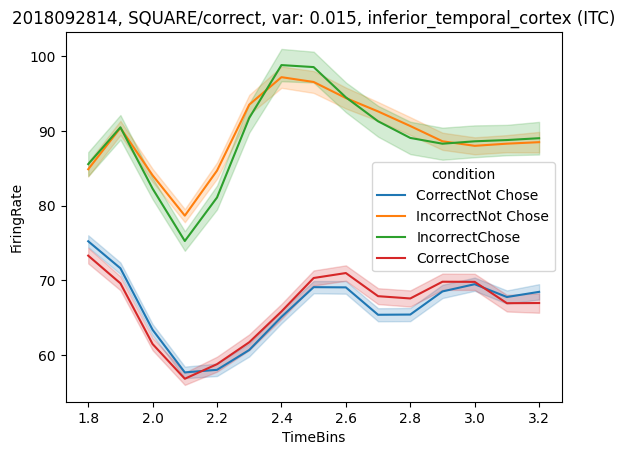

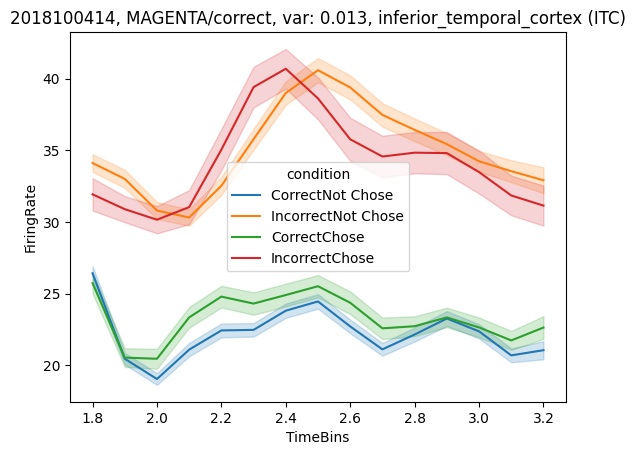

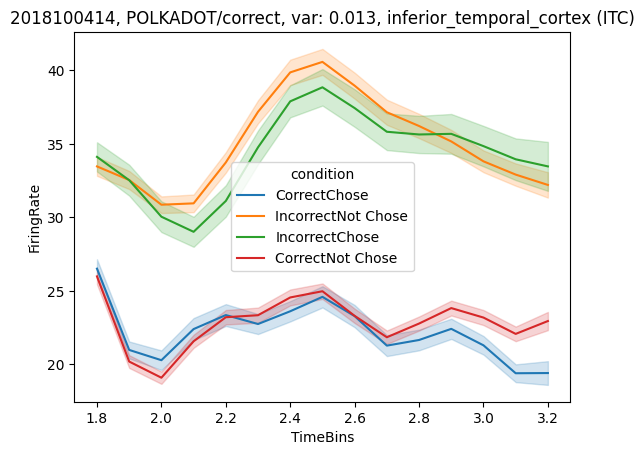

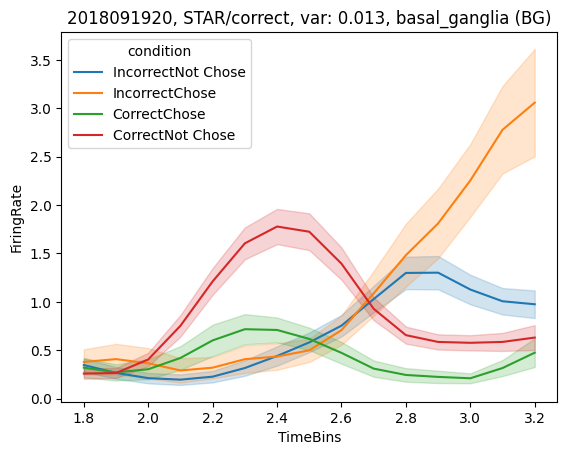

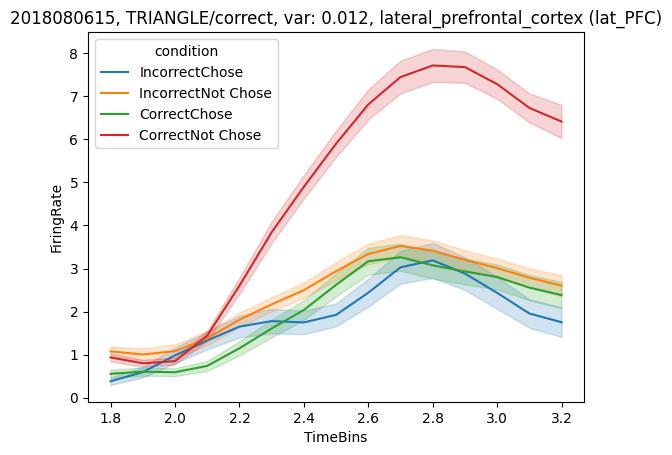

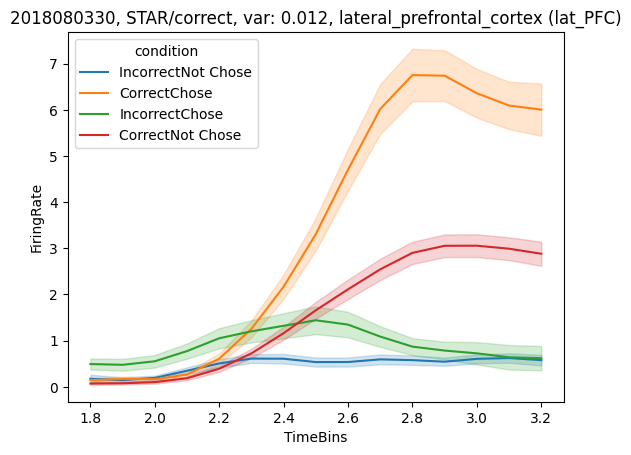

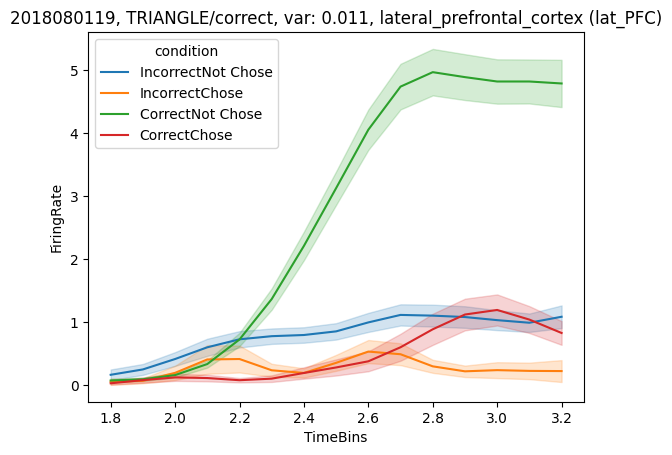

In [35]:
to_vis = good_int_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, ax = plt.subplots()
    sns.lineplot(data, x="TimeBins", y="FiringRate", errorbar="se", hue="condition", ax=ax)
    ax.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

### Visualize a few for preferred/not preferred, conditioning on choosing the feature, getting it correct, and the preferred feature being on the chosen card

In [43]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}



In [44]:
good_pref_res = read_good_units(args)

In [45]:
good_pref_res.PseudoUnitID.nunique()

386

In [46]:
good_pref_res.groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
amygdala (Amy)                               26
anterior_cingulate_gyrus (ACgG)              31
basal_ganglia (BG)                           27
cerebellum (Cb)                               1
extrastriate_visual_areas_2-4 (V2-V4)         5
floor_of_the_lateral_sulcus (floor_of_ls)     4
inferior_parietal_lobule (IPL)               17
inferior_temporal_cortex (ITC)               63
lateral_and_ventral_pallium (LVPal)          32
lateral_prefrontal_cortex (lat_PFC)          93
medial_pallium (MPal)                        16
motor_cortex (motor)                         19
orbital_frontal_cortex (OFC)                 15
posterior_medial_cortex (PMC)                 7
preoptic_complex (POC)                        1
primary_visual_cortex (V1)                    6
superior_parietal_lobule (SPL)               17
thalamus (Thal)                               5
unknown                                       1
Name: PseudoUnitID, dtype: int64

In [ ]:
def visualize_scatter(subject, session, pseudo_unit_id, beh, trial_interval):
    # unit_frs = frs[frs.PseudoUnitID == pseudo_unit_id]
    # fr_data = pd.merge(beh, unit_frs, on="TrialNumber")

    spike_times = spike_general.get_spike_times(None, subject, session, species_dir="/data")
    intervals = behavioral_utils.get_trial_intervals(beh, trial_interval.event, trial_interval.pre_interval, trial_interval.post_interval)
    spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
    spike_by_trial_interval.TrialNumber = spike_by_trial_interval.TrialNumber.astype(int)

    unit_spikes = spike_by_trial_interval[spike_by_trial_interval.UnitID == int(pseudo_unit_id % 100)]
    unit_spikes["X"] = (unit_spikes.SpikeTimeFromStart - trial_interval.pre_interval) / 1000
    sorted_beh = beh.sort_values(by=["condition", "TrialNumber"], ascending=False)
    sorted_beh["Y"] = range(len(sorted_beh))
    unit_spikes = pd.merge(unit_spikes, sorted_beh["TrialNumber", "Y", "condition"], on="TrialNumber")
    sns.scatterplot(unit_spikes, x="X", y="Y", hue="condition", marker="_", linewidths=1,)


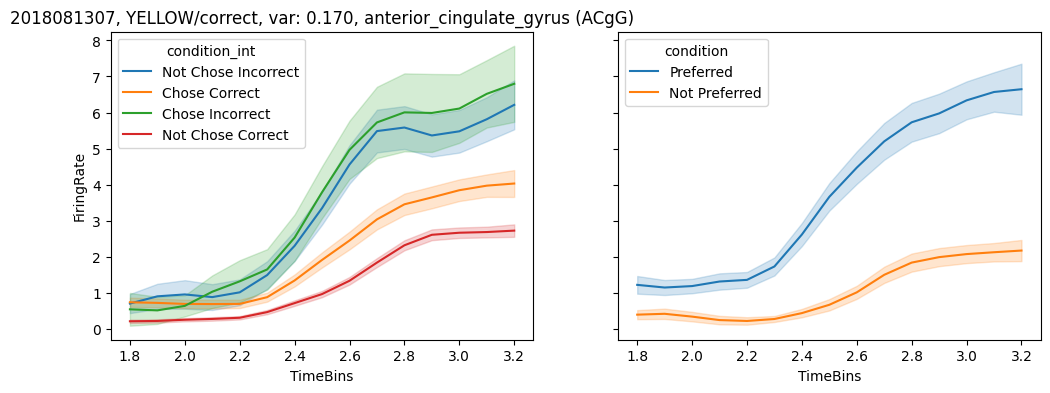

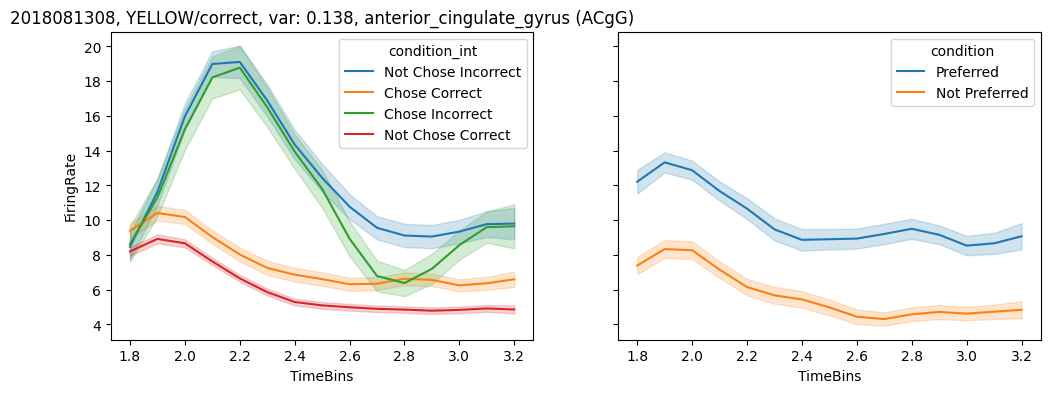

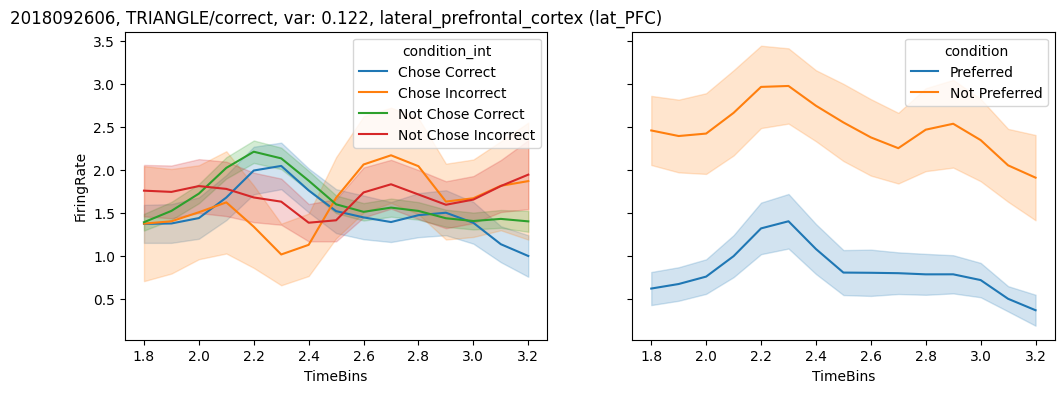

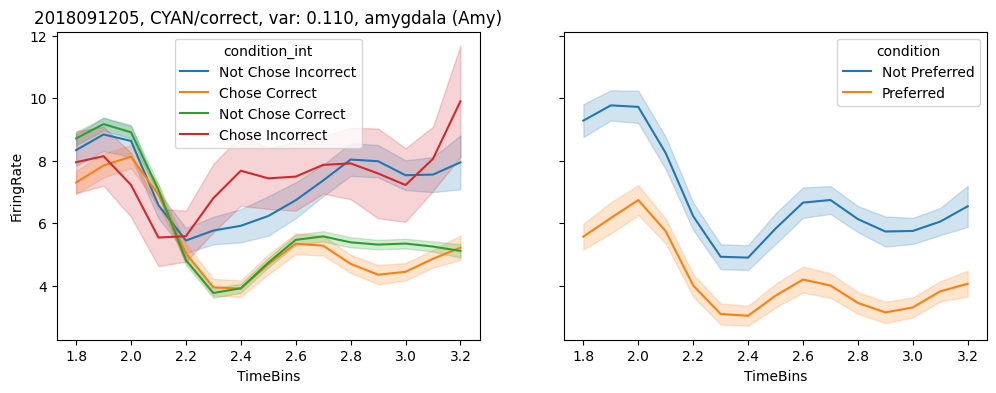

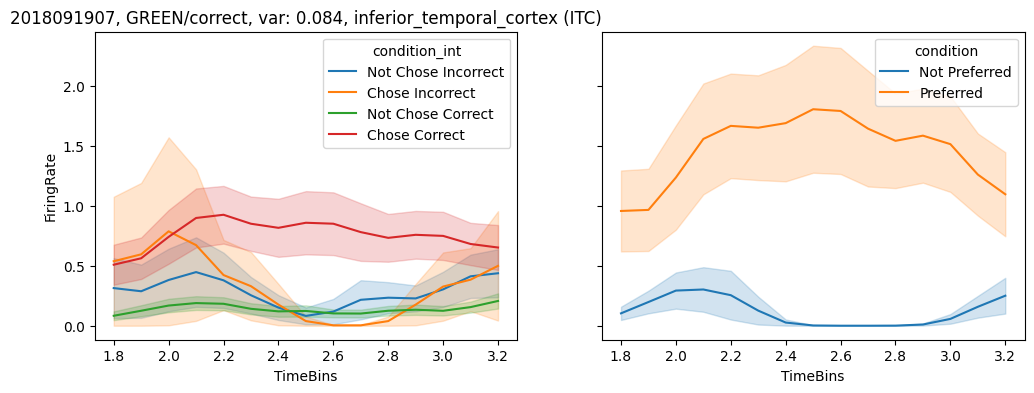

In [47]:
to_vis = good_pref_res.sort_values("combined_fracvar", ascending=False)[:5]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    args.beh_filters = {"PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition_int"] = data.apply(lambda x: " ".join([x[cond] for cond in ["Choice", "Response"]]), axis=1)
    sns.lineplot(data, x="TimeBins", y="FiringRate", hue="condition_int", errorbar="se", ax=ax1)

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    sns.lineplot(data, x="TimeBins", y="FiringRate", hue="condition", errorbar="se", ax=ax2)


    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")